### Introduction

This is the code that can propagates
color over regions exhibiting pattern-continuity as well as intensity-
continuity. This method works effectively on colorizing
black-and-white manga which contains intensive amount of strokes,
hatching, halftoning and screening. Such fine details and discon-
tinuities in intensity introduce many difficulties to intensity-based
colorization methods. Once the user scribbles on the drawing, a
local, statistical based pattern feature obtained with Gabor wavelet
filters is applied to measure the pattern-continuity. The boundary is
then propagated by the distance regularized level set method that monitors the pattern-
continuity. Regions with open boundaries or multiple disjointed
regions with similar patterns can be sensibly segmented by a single
scribble. With the segmented regions, various colorization tech-
niques can be applied to replace colors, colorize with stroke preser-
vation, or even convert pattern to shading.


### Distance Regularized Level Set Method

Level set methods have been widely used in image processing and computer vision. In conventional level set formulations, the level set function typically develops irregularities during its evolution, which may cause numerical errors and eventually destroy the stability of the evolution. Therefore, a numerical remedy, called reinitialization, is typically applied to periodically replace the degraded level set function with a signed distance function. However, the practice of reinitialization not only raises serious problems as when and how it should be performed, but also affects numerical accuracy in an undesirable way. 

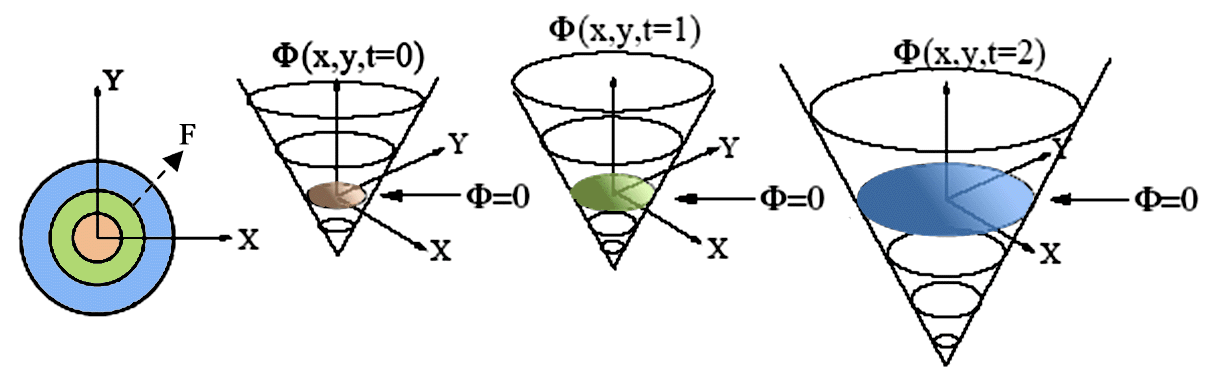

In this method, we have used a new variational level set formulation in which the regularity of the level set function is intrinsically maintained during the level set evolution. The level set evolution is derived as the gradient flow that minimizes an energy functional with a distance regularization term and an external energy that drives the motion of the zero level set toward desired locations. The distance regularization term is defined with a potential function such that the derived level set evolution has a unique forward-and-backward (FAB) diffusion effect, which is able to maintain a desired shape of the level set function, particularly a signed distance profile near the zero level set. This yields a new type of level set evolution called distance regularized level set evolution (DRLSE). The distance regularization effect eliminates the need for reinitialization and thereby avoids its induced numerical errors. In contrast to complicated implementations of conventional level set formulations, a simpler and more efficient finite difference scheme can be used to implement the DRLSE formulation. 

DRLSE also allows the use of more general and efficient initialization of the level set function. In its numerical implementation, relatively large time steps can be used in the finite difference scheme to reduce the number of iterations, while ensuring sufficient.

### Application to Image Segmentation

The general DRLSE formulation in can be used in various applications with different definitions of the external energy Eext. For image segmentation applications, a variety of image information, including region-based or edge-based image formation, can be used to define the external energy.

Let I be an image on a domain $Ω$, we define an edge indicator function $g$ by

$$g \triangleq {1\over 1+\vert \nabla G_\sigma\ast I\vert^2}$$

where $Gσ$ is a Gaussian kernel with a standard deviation $σ$. The convolution in is used to smooth the image to reduce the noise. This function $g$ usually takes smaller values at object boundaries than at other locations.

For an LSF $ϕ:Ω→R$, we define an energy functional $E(ϕ)$ by

$${\cal E}(\phi) = \mu{\cal R}_p(\phi) + \lambda {\cal L}_g(\phi) + \alpha{\cal A}_g(\phi)$$

where $λ>0$ and $α∈R$ are the coefficients of the energy functionals $Lg(ϕ)$ and $Ag(ϕ)$, which are defined by

$$\eqalignno{{\cal L}_g(\phi) &\triangleq \int_{\Omega} g \delta(\phi) \vert \nabla \phi\vert d{\bf x} \cr {\hbox {and}} {\cal A}_g(\phi) &\triangleq \int_\Omega g H(-\phi)d{\bf x} }$$



### Result on applying DRLSE to an Image


In [1]:
from scipy.misc import imread
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import scipy.ndimage.filters as filters
from skimage import measure
import numpy as np
import level_set

/home/neil/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  """Entry point for launching an IPython kernel.


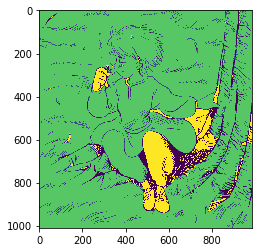

In [2]:
image = imread('123.png', True)
plt.imshow(image)

/home/neil/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  """Entry point for launching an IPython kernel.


[0.00000000e+00 1.45519152e-11 3.27418093e-11 ... 1.47670205e+04
 1.47716904e+04 1.47789590e+04]
0


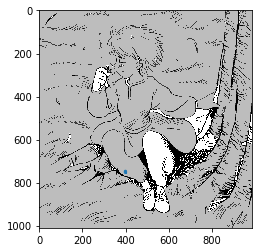

20


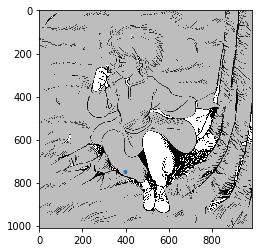

40


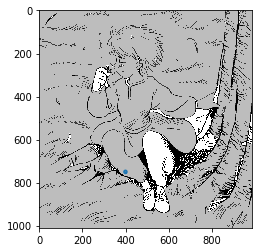

60


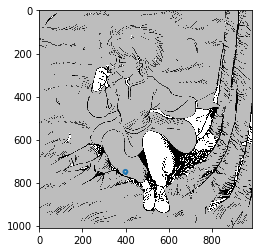

80


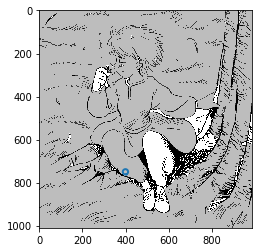

100


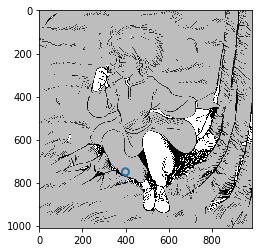

120


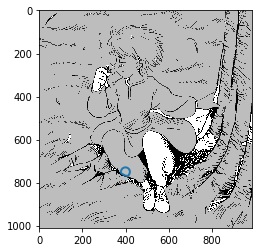

140


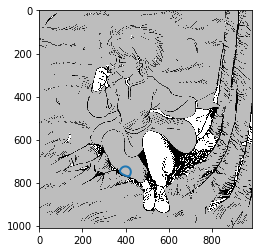

160


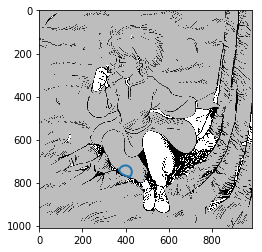

180


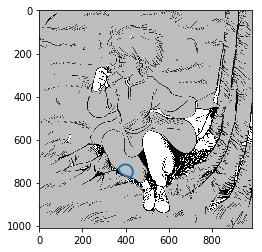

200


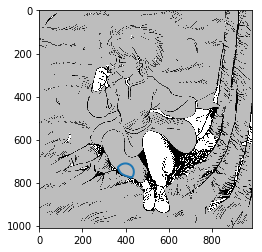

220


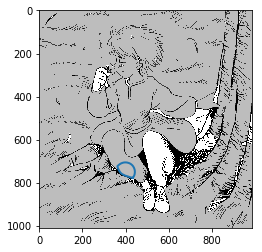

240


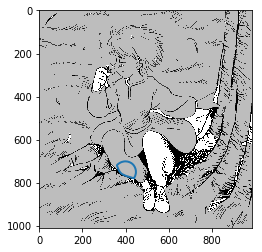

260


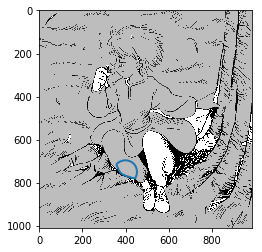

280


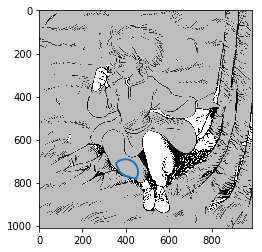

300


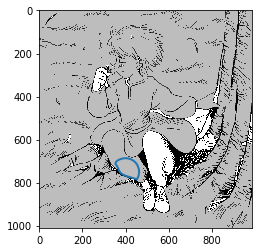

320


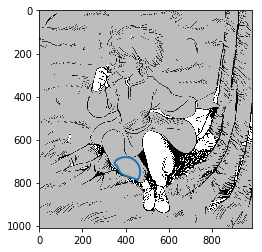

340


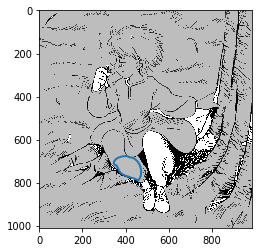

360


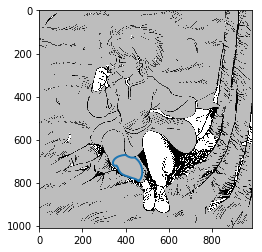

380


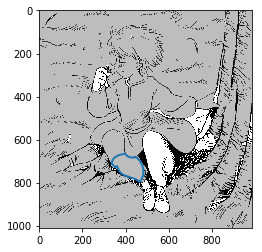

400


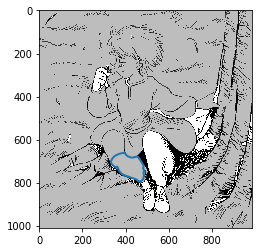

420


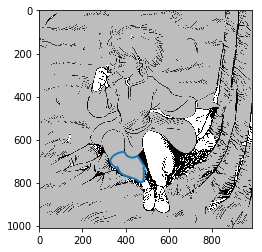

440


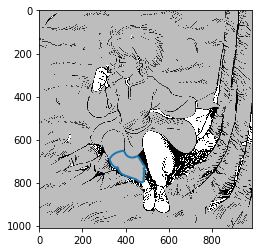

460


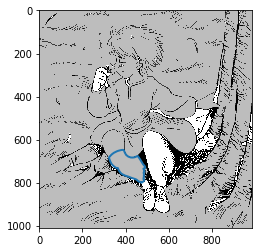

480


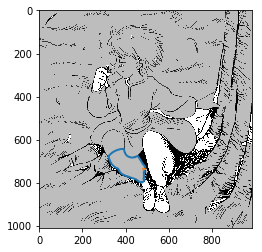

500


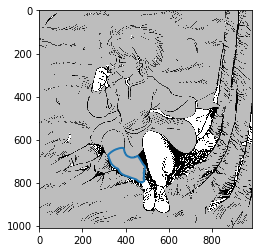

520


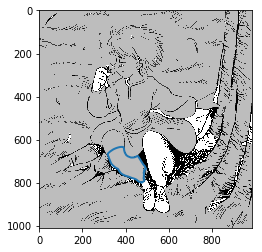

540


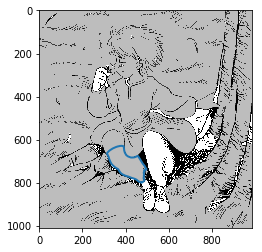

560


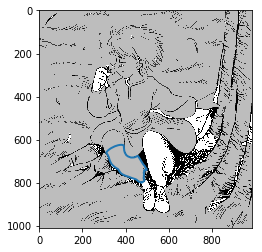

580


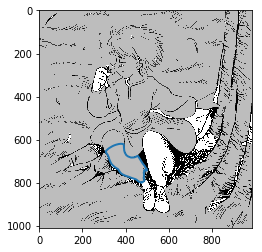

600


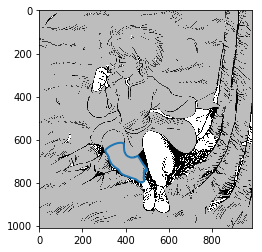

620


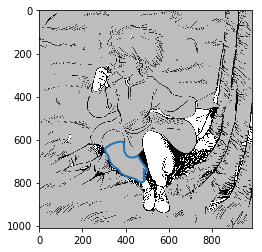

640


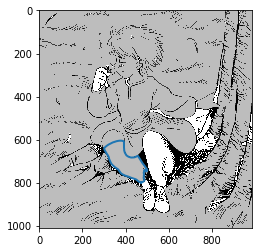

660


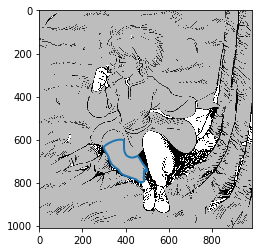

680


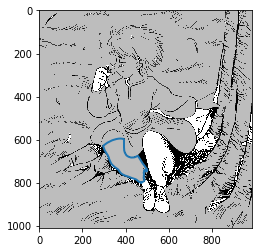

700


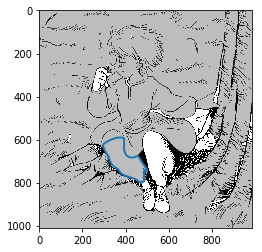

720


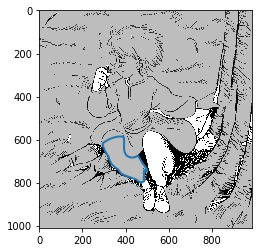

740


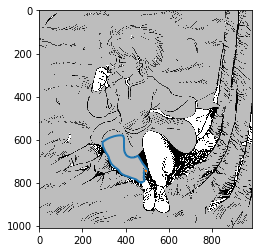

760


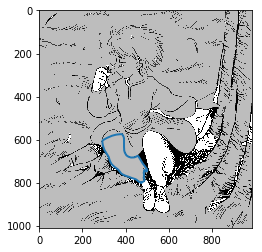

780


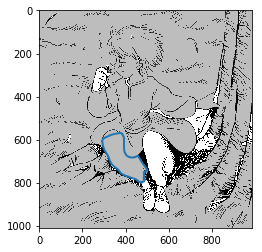

800


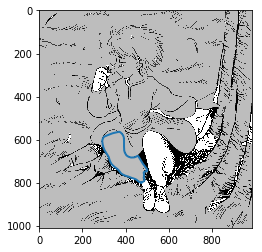

820


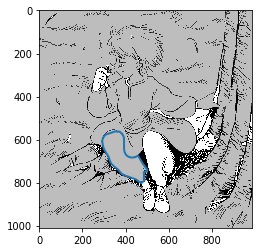

840


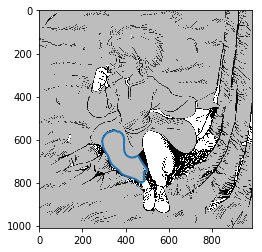

860


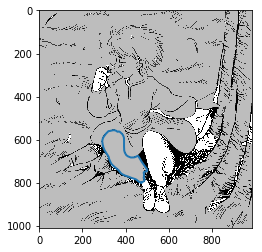

880


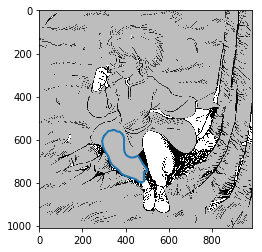

900


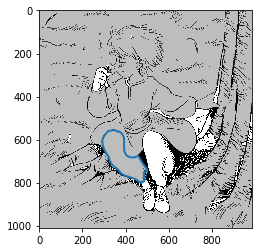

920


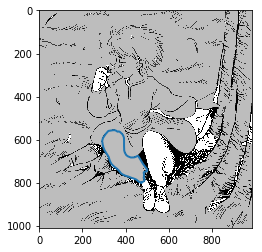

940


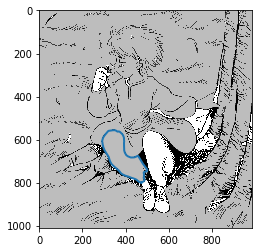

960


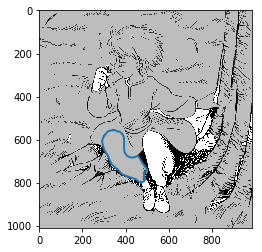

980


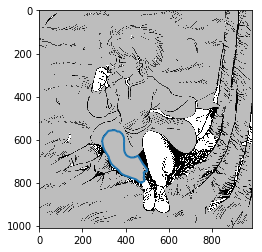

1000


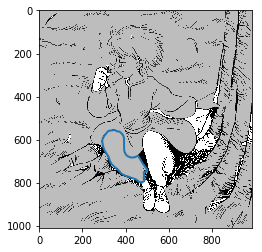

In [3]:
image = imread('123.png', True)
image = np.array(image,dtype='float32')
LS = level_set.levelSet(4,1001,2,-1.1,2.0,0.8)
LS.gradientDescent(image,750,400)

### Conclusion

- We've finished coding the DRLSE variant of level set method that can detect region
- We're working on implementing Gabor wavelet method for finding feature set in pattern continuous region
- We're working on how to apply colors to these regions

In [ ]:
from scipy.misc import imread
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import scipy.ndimage.filters as filters
from skimage import measure
import numpy as np

class drlse(object):

	def __init__(self, F, lamda, mu, alpha, epsilon, dt, iterations, potential_function, M1, M2, F1):
		self.F = F
		self.lamda = lamda
		self.alpha = alpha
		self.epsilon = epsilon
		self.dt = dt
		self.mu = mu
		self.iter = iterations
		self.potential_function = potential_function
		self.M1 = M1
		self.M2 = M2
		self.F1 =F1

	def sigmoid(self, x):
		return np.exp(x)/(1+ np.exp(x))

	def drlse_edge(self,phi):
		[vy, vx] = np.gradient(self.F)
		for k in range(self.iter):
		    phi = self.applyNeumann(phi)
		    [phi_y, phi_x] = np.gradient(phi)
		    s = np.sqrt(np.square(phi_x) + np.square(phi_y))
		    smallNumber = 1e-10
		    Nx = phi_x / (s + smallNumber)
		    Ny = phi_y / (s + smallNumber)
		    curvature = self.div(Nx, Ny)
		    if self.potential_function == 'single-well':
		        distRegTerm = filters.laplace(phi, mode='wrap') - curvature
		    elif self.potential_function == 'double-well':
		        distRegTerm = self.distReg_p2(phi)
		    else:
		        print('Error: Wrong choice of potential function. Please input the string "single-well" or "double-well" in the drlse_edge function.')
		    diracPhi = self.Dirac(phi)
		    areaTerm = diracPhi * self.F
		    edgeTerm = diracPhi * (vx * Nx + vy * Ny) + diracPhi*self.F * curvature
		    x = (self.F1 - self.M2)/(self.M1 - self.M2)
		    leakproofterm = self.F*areaTerm*self.sigmoid(x)
		    phi = phi + self.dt * (self.mu * distRegTerm + self.lamda * edgeTerm + self.alpha * areaTerm - leakproofterm*self.alpha)
		return phi

	def distReg_p2(self,phi):
	    [phi_y, phi_x] = np.gradient(phi)
	    s = np.sqrt(np.square(phi_x) + np.square(phi_y))
	    a = (s >= 0) & (s <= 1)
	    b = (s > 1)
	    ps = a * np.sin(2 * np.pi * s) / (2 * np.pi) + b * (s - 1)
	    dps = ((ps != 0) * ps + (ps == 0)) / ((s != 0) * s + (s == 0))
	    return self.div(dps * phi_x - phi_x, dps * phi_y - phi_y) + filters.laplace(phi, mode='wrap')

	def div(self,nx, ny):
	    [junk, nxx] = np.gradient(nx)
	    [nyy, junk] = np.gradient(ny)
	    return nxx + nyy

	def Dirac(self,x):
	    f = (1 / 2 / self.epsilon) * (1 + np.cos(np.pi * x / self.epsilon))
	    b = (x <= self.epsilon) & (x >= -self.epsilon)
	    return f * b

	def applyNeumann(self,f):
	    [ny, nx] = f.shape
	    g = f.copy()
	    g[0, 0] = g[2, 2]
	    g[0, nx-1] = g[2, nx-3]
	    g[ny-1, 0] = g[ny-3, 2]
	    g[ny-1, nx-1] = g[ny-3, nx-3]

	    g[0, 1:-1] = g[2, 1:-1]
	    g[ny-1, 1:-1] = g[ny-3, 1:-1]

	    g[1:-1, 0] = g[1:-1, 2]
	    g[1:-1, nx-1] = g[1:-1, nx-3]
	    return g



class levelSet(object):

	def __init__(self, drlse_iter, gradient_iter, lamda, alpha, epsilon, sigma, dt=1, potential_function="double-well"):
		self.lamda = lamda
		self.alpha = alpha
		self.epsilon = epsilon
		self.sigma = sigma
		self.dt = dt
		self.mu = 0.2/self.dt
		self.drlse_iter = drlse_iter
		self.gradient_iter = gradient_iter
		self.potential_function = potential_function

	def initializePhiAtScribble(self,image,x,y):
		c0 = 4
		phi = c0 * np.ones(image.shape)
		phi[x-5:x+5, y-3:y+3] = -c0
		return phi

	def visualization(self,image,phi):
		fig2 = plt.figure(2)
		fig2.clf()
		contours = measure.find_contours(phi, 0)
		ax2 = fig2.add_subplot(111)
		ax2.imshow(image, interpolation='nearest', cmap=plt.cm.gray)
		for n, contour in enumerate(contours):
			ax2.plot(contour[:, 1], contour[:, 0], linewidth=2)

	def calculateF(self,image):
		img_smooth = filters.gaussian_filter(image, self.sigma)
		[Iy, Ix] = np.gradient(img_smooth)
		f = np.square(Ix) + np.square(Iy)
		f1 = np.sqrt(f)
		print(np.unique(f))
		return 1 / (1+f), np.max(f1), np.min(f1), f1

	def gradientDescent(self,image,x,y):
		phi = self.initializePhiAtScribble(image,x,y)
		F, M1, M2, F1 = self.calculateF(image)
		lse = drlse(F, self.lamda, self.mu, self.alpha, self.epsilon, self.dt, self.drlse_iter, self.potential_function, M1, M2, F1)
		for n in range(self.gradient_iter):
			phi = lse.drlse_edge(phi)
			#print(np.unique(phi))
			#plt.show()
			if np.mod(n, 20) == 0:			
				self.visualization(image,phi)
				print(n)
				plt.pause(0.3)
		plt.pause(5)

def main():

	# iter_inner, iter_outer, lamda, alpha, epsilon, sigma, dt, potential_function
	# potential_function="single-well"

	image = imread('123.png', True)
	image = np.array(image,dtype='float32')
	LS = levelSet(4,101,2,-0.1,2.0,0.8)
	LS.gradientDescent(image,240,150)


if __name__ == '__main__':
	main()


In [ ]:
from scipy.misc import imread
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import scipy.ndimage.filters as filters
from skimage import measure
import numpy as np

class drlse(object):

	def __init__(self, F, lamda, mu, alpha, epsilon, dt, iterations, potential_function, M1, M2, F1):
		self.F = F
		self.lamda = lamda
		self.alpha = alpha
		self.epsilon = epsilon
		self.dt = dt
		self.mu = mu
		self.iter = iterations
		self.potential_function = potential_function
		self.M1 = M1
		self.M2 = M2
		self.F1 =F1

	def sigmoid(self, x):
		return np.exp(x)/(1+ np.exp(x))

	def drlse_edge(self,phi):
		[vy, vx] = np.gradient(self.F)
		for k in range(self.iter):
		    phi = self.applyNeumann(phi)
		    [phi_y, phi_x] = np.gradient(phi)
		    s = np.sqrt(np.square(phi_x) + np.square(phi_y))
		    smallNumber = 1e-10
		    Nx = phi_x / (s + smallNumber)
		    Ny = phi_y / (s + smallNumber)
		    curvature = self.div(Nx, Ny)
		    if self.potential_function == 'single-well':
		        distRegTerm = filters.laplace(phi, mode='wrap') - curvature
		    elif self.potential_function == 'double-well':
		        distRegTerm = self.distReg_p2(phi)
		    else:
		        print('Error: Wrong choice of potential function. Please input the string "single-well" or "double-well" in the drlse_edge function.')
		    diracPhi = self.Dirac(phi)
		    areaTerm = diracPhi * self.F
		    edgeTerm = diracPhi * (vx * Nx + vy * Ny) + diracPhi*self.F * curvature
		    x = (self.F1 - self.M2)/(self.M1 - self.M2)
		    leakproofterm = self.F*areaTerm*self.sigmoid(x)
		    phi = phi + self.dt * (self.mu * distRegTerm + self.lamda * edgeTerm + self.alpha * areaTerm + leakproofterm)
		return phi

	def distReg_p2(self,phi):
	    [phi_y, phi_x] = np.gradient(phi)
	    s = np.sqrt(np.square(phi_x) + np.square(phi_y))
	    a = (s >= 0) & (s <= 1)
	    b = (s > 1)
	    ps = a * np.sin(2 * np.pi * s) / (2 * np.pi) + b * (s - 1)
	    dps = ((ps != 0) * ps + (ps == 0)) / ((s != 0) * s + (s == 0))
	    return self.div(dps * phi_x - phi_x, dps * phi_y - phi_y) + filters.laplace(phi, mode='wrap')

	def div(self,nx, ny):
	    [junk, nxx] = np.gradient(nx)
	    [nyy, junk] = np.gradient(ny)
	    return nxx + nyy

	def Dirac(self,x):
	    f = (1 / 2 / self.epsilon) * (1 + np.cos(np.pi * x / self.epsilon))
	    b = (x <= self.epsilon) & (x >= -self.epsilon)
	    return f * b

	def applyNeumann(self,f):
	    [ny, nx] = f.shape
	    g = f.copy()
	    g[0, 0] = g[2, 2]
	    g[0, nx-1] = g[2, nx-3]
	    g[ny-1, 0] = g[ny-3, 2]
	    g[ny-1, nx-1] = g[ny-3, nx-3]

	    g[0, 1:-1] = g[2, 1:-1]
	    g[ny-1, 1:-1] = g[ny-3, 1:-1]

	    g[1:-1, 0] = g[1:-1, 2]
	    g[1:-1, nx-1] = g[1:-1, nx-3]
	    return g



class levelSet(object):

	def __init__(self, drlse_iter, gradient_iter, lamda, alpha, epsilon, sigma, dt=1, potential_function="double-well"):
		self.lamda = lamda
		self.alpha = alpha
		self.epsilon = epsilon
		self.sigma = sigma
		self.dt = dt
		self.mu = 0.2/self.dt
		self.drlse_iter = drlse_iter
		self.gradient_iter = gradient_iter
		self.potential_function = potential_function

	def initializePhiAtScribble(self,image,x,y):
		c0 = 4
		phi = c0 * np.ones(image.shape)
		phi[x-5:x+5, y-3:y+3] = -c0
		return phi

	def visualization(self,image,phi):
		fig2 = plt.figure(2)
		fig2.clf()
		contours = measure.find_contours(phi, 0)
		ax2 = fig2.add_subplot(111)
		ax2.imshow(image, interpolation='nearest', cmap=plt.cm.gray)
		for n, contour in enumerate(contours):
			ax2.plot(contour[:, 1], contour[:, 0], linewidth=2)

	def calculateF(self,image):
		img_smooth = filters.gaussian_filter(image, self.sigma)
		[Iy, Ix] = np.gradient(img_smooth)
		f = np.square(Ix) + np.square(Iy)
		f1 = np.sqrt(f)
		print(np.unique(f))
		return 1 / (1+f), np.max(f1), np.min(f1), f1

	def gradientDescent(self,image,x,y):
		phi = self.initializePhiAtScribble(image,x,y)
		F, M1, M2, F1 = self.calculateF(image)
		lse = drlse(F, self.lamda, self.mu, self.alpha, self.epsilon, self.dt, self.drlse_iter, self.potential_function, M1, M2, F1)
		for n in range(self.gradient_iter):
			phi = lse.drlse_edge(phi)
			#print(np.unique(phi))
			#plt.show()
			if np.mod(n, 20) == 0:			
				self.visualization(image,phi)
				plt.pause(0.3)
		plt.pause(5)

def main():

	# iter_inner, iter_outer, lamda, alpha, epsilon, sigma, dt, potential_function
	# potential_function="single-well"

	image = imread('123.png', True)
	image = np.array(image,dtype='float32')
	LS = levelSet(4,101,2,-9,2.0,0.8)
	LS.gradientDescent(image,240,150)


if __name__ == '__main__':
	main()
